# Import libraries to download Alpha Vantage Datasets

To access Alpha Vantage users need an API key which are given for free on the Alpha Vantage website. This key is listed in a json called creds.json. Here we download stock data using the alpha vantage API. This API enables us to get any stocks data, in which we collect;
 1. Microsoft
 2. Google
 3. Tesla
 4. Apple
 5. Netflix
 6. Beyond Meat
 
These stocks and more are listed in the file "Stock Symbols.txt". This dataset is from 1999 up to today's date and returns daily intervals.
 The data retrieved is formated to csv with date, open price, highest price, lowest price, closing price and the stocks volume all in headings.
 The CSVs produced are then saved to a folder called Stockcsvs and a txt file indicating the amount of calls made to alpha vantage will also be printed to the root directory.

In [6]:
from alpha_vantage.timeseries import TimeSeries
from pprint import pprint
import json
import argparse
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import os
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

apiKey = 'X5R4ATFGQ5WSGI6K'

In [ ]:
from alpha_vantage.timeseries import TimeSeries
from pprint import pprint
import time
from datetime import datetime
import os
import json

# Prevent going over API call limit that Alpha Vantage enforces
stringptime = datetime.now()
current_date = stringptime.strftime('%d-%m-%Y')
count = 0


def check_count():
    global count, current_date
    if os.path.isfile(f'{current_date}.txt'):
        with open(f'{current_date}.txt', 'r') as f:
            temp = f.readline()
            
            #Clean null values
            temp.replace("'", "")
            temp.strip() 
            count = int(temp)
            count += 1
            # print(count)
        with open(f'{current_date}.txt', 'w') as f:
            f.write(str(count))
            # print(count)

    else:
        with open(f'{current_date}.txt', 'w') as f:
            f.write(str(count))
            # print(count)
    return count

# Save the data to a CSV
def save_dataset(symbol, time_window):
    credentials = json.load(open('creds.json', 'r'))
    api_key = credentials['av_api_key']
    # print(symbol, time_window)
    ts = TimeSeries(key=api_key, output_format='pandas')
    if time_window == 'intraday':
        data, meta_data = ts.get_intraday(
            symbol = symbol, interval='1min', outputsize='full')
    elif time_window == 'daily':
        data, meta_data = ts.get_daily(symbol, outputsize='full')
    elif time_window == 'daily_adj':
        data, meta_data = ts.get_daily_adjusted(symbol, outputsize='full')

    print(symbol, 'info saved as ' + f'{symbol}_{time_window}.csv')
    print('*' * 58)
    pprint(data.head(1))
    print('-' * 58)
    pprint(data.tail(1))
    print('*' * 58)
    print()
    data.to_csv(f'./Stockcsvs/{symbol}_{time_window}.csv')


if __name__ == "__main__":

    if count <= 500:  # 500 calls per day
        # Get the stock ticker list from text file and go download each dataset
        with open('Stock symbols.txt', 'r') as f:
            symbol_list = [i.replace('\n', '') for i in f]
    
        for symbols in symbol_list:
            if check_count() <= 500:
                print('*' * 58)
                print('API calls today:', count)
                print('Getting data for stock ' + symbols)
                
                # Daily intervals of Stock Data
                save_dataset(symbols, 'daily')
                
                # Limit to 5 API requests per minute max 500 per day
                time.sleep(13)
            else:
                print('You have exceeded you max API calls for the day')
                print('Try again tomorrow.')

# Import additional libraries and Test GPU devices

TensorFlow is an extremley delicate library and finding a suitable version can be hard. We recommend using v2.1.0 as it has Keras built in and offers GPU support. Pandas and numpy are imported here to allow for large data manipulation. The GPU availability is run to check the GPU is available for TensorFlow and will be used during model learning.

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
#from tensorflow.keras.models import *
#from tensorflow.keras.layers import *
from tensorflow.keras.layers import *

print('Tensorflow: {}'.format(tf.__version__))



import warnings
warnings.filterwarnings('ignore')

tf.config.list_physical_devices('GPU')

from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

#%run pre_processing.ipyn

Tensorflow: 2.1.0
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5



# Declare Hyperparameter

A hyperparameter is dimensionality of the input.This denotes the LSTMs single optimization steps.

In [8]:
hyp_par_len = 75

# Get the Data from a saved CSV.

The data is then sorted into what will be used. We use all the columns as they all show good insications of stock value and may be used later. Here, zero values were creating an error so pandas is used to fill zero values with previous ones and null values are dropped.
Pandas is also used here to produce a moving average over n days, (12) in out program.

In [9]:

cvs_path = (r'.\Stockcsvs\IBM_daily.csv')

df = pd.read_csv(cvs_path, delimiter=',', usecols=['date', '1. open', '2. high', '3. low', '4. close', '5. volume'])

# 0 values are causing a division error, ffill propogates last observation
df['5. volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('date', inplace=False)
df.tail()

df[['1. open', '2. high', '3. low', '4. close', '5. volume']] = df[['1. open', '2. high', '3. low', '4. close', '5. volume']].rolling(5).mean()

df.dropna(how='any', axis=0, inplace=True)

df.head

<bound method NDFrame.head of             date    1. open   2. high     3. low  4. close   5. volume
4     2021-01-27  120.87200  122.2480  119.72028   120.328   8923695.4
5     2021-01-26  120.83600  122.5660  119.54828   120.938   9800260.8
6     2021-01-25  120.60848  122.2836  119.29228   120.546  11287437.4
7     2021-01-22  120.70448  122.1636  118.98428   120.446  16535044.8
8     2021-01-21  122.16848  123.9716  120.98028   122.760  17482081.2
...          ...        ...       ...        ...       ...         ...
5343  1999-11-05   94.08600   95.3880   92.36000    93.962   9527780.0
5344  1999-11-04   93.47400   94.7760   91.38600    93.274  11437800.0
5345  1999-11-03   93.72400   94.5520   91.26200    92.748  11775560.0
5346  1999-11-02   94.06200   94.8140   91.57600    92.986  12086400.0
5347  1999-11-01   95.66200   95.7880   92.75000    93.548  12292300.0

[5344 rows x 6 columns]>

# Visualise the Data

After many tests it is conclusive that on a learning basis, volatile data is better for learning, an easy way to know the volatility of your data is to visualise it. Matplotlib is used for this task, providing clear representation of closing prices and volume as moving averages over time, although the graph has to be inverted to be readable.

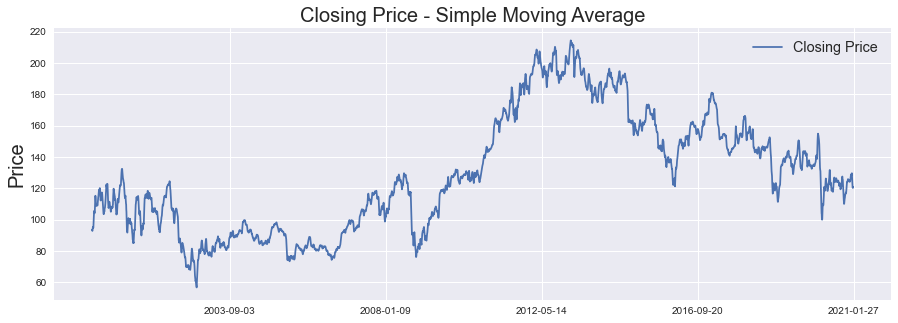

In [10]:
#Plot Closing Price
plt.figure(figsize=(15, 5))
plt.plot(df['4. close'])
plt.xticks(range(0, df.shape[0], 1095), df['date'].loc[::1095], rotation=0)
plt.ylabel('Price', fontsize=20)
plt.title("Closing Price - Simple Moving Average", fontsize=20)
plt.legend(['Closing Price'], fontsize='x-large', loc='best')
#invert for left to right reading
plt.gca().invert_xaxis()
plt.show()

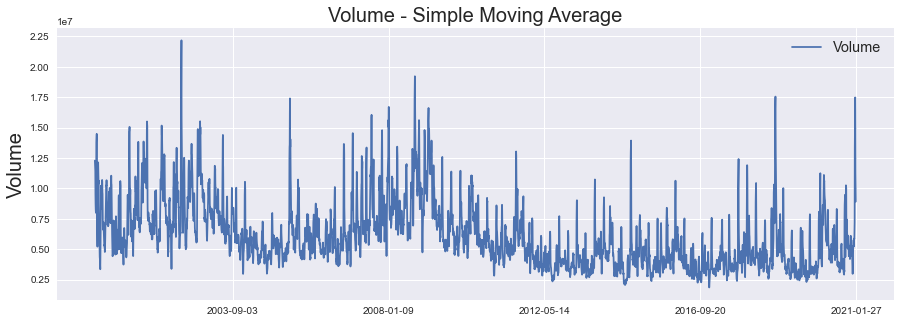

In [11]:
#Plot Volume
plt.figure(figsize=(15, 5))
plt.plot(df['5. volume'])
plt.xticks(range(0, df.shape[0], 1095), df['date'].loc[::1095], rotation=0)
plt.ylabel('Volume', fontsize=20)
plt.title("Volume - Simple Moving Average", fontsize=20)
plt.legend(['Volume'], fontsize='x-large', loc='best')
#invert for left to right reading
plt.gca().invert_xaxis()
plt.show()

# Normalise the Data

As specific time periods have volatile price ranges, percentage change between one point and the previous is calculated now the min max function scales all data between 0 and 1 this stops the data becoming unreadable later in the modeol. SciKit learn could have been used here but the MinMaxScaler funtion drops the column names which we must keep.

In [12]:
#Calculate the normalised percentage change in each column

df['1. open'] = df['1. open'].pct_change()
df['2. high'] = df['2. high'].pct_change()
df['3. low'] = df['3. low'].pct_change()
df['4. close'] = df['4. close'].pct_change()
df['5. volume'] = df['5. volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True)

#Price
min_ret = min(df[['1. open', '2. high', '3. low', '4. close']].min(axis=0))
max_ret = max(df[['1. open', '2. high', '3. low', '4. close']].max(axis=0))

df['1. open'] = (df['1. open'] - min_ret) / (max_ret - min_ret)
df['2. high'] = (df['2. high'] - min_ret) / (max_ret - min_ret)
df['3. low'] = (df['3. low'] - min_ret) / (max_ret - min_ret)
df['4. close'] = (df['4. close'] - min_ret) / (max_ret - min_ret)

#Volume
min_volume = df['5. volume'].min(axis=0)
max_volume = df['5. volume'].max(axis=0)

df['5. volume'] = (df['5. volume'] - min_volume) / (max_volume - min_volume)

# Split the Data in to Training, Validation and Testing

Now split the dataset into training, validation and testing sets. Here the split is 70% Training, 15% Validation and then 15% Testing data. All this data is spilt sequentially to give the data linearity in the learning as this is how the market is perceived.

In [13]:
# Split data into training, validation and test subsets
times = sorted(df.index.values)
last_15pct = sorted(df.index.values)[-int(0.15*len(times))]
last_30pct = sorted(df.index.values)[-int(0.30*len(times))]

df_training = df[(df.index < last_30pct)]
df_validation = df[(df.index >= last_30pct) & (df.index < last_15pct)]
df_test = df[(df.index >= last_15pct)]

# Date gets removed
df_training.drop(columns=['date'], inplace=True)
df_validation.drop(columns=['date'], inplace=True)
df_test.drop(columns=['date'], inplace=True)

# Make arrays
train_data = df_training.values
val_data = df_validation.values
test_data = df_test.values
print('Training shape: {}'.format(train_data.shape))
print('Validation shape: {}'.format(val_data.shape))
print('Test shape: {}'.format(test_data.shape))

df_training.head()

Training shape: (3741, 5)
Validation shape: (801, 5)
Test shape: (801, 5)


,1. open,2. high,3. low,4. close,5. volume
5,0.534425,0.562808,0.523275,0.586972,0.480962
6,0.518907,0.514783,0.516376,0.505607,0.517508
7,0.545133,0.527733,0.512063,0.529219,0.731351
8,0.656085,0.682235,0.701575,0.725430,0.452996
9,0.659470,0.636371,0.649641,0.658722,0.362733


# Visualise Daily Changes

Here we create graphs to visualise the volatility in the stock. As the data has been normalized the information lies between 1 and 0.

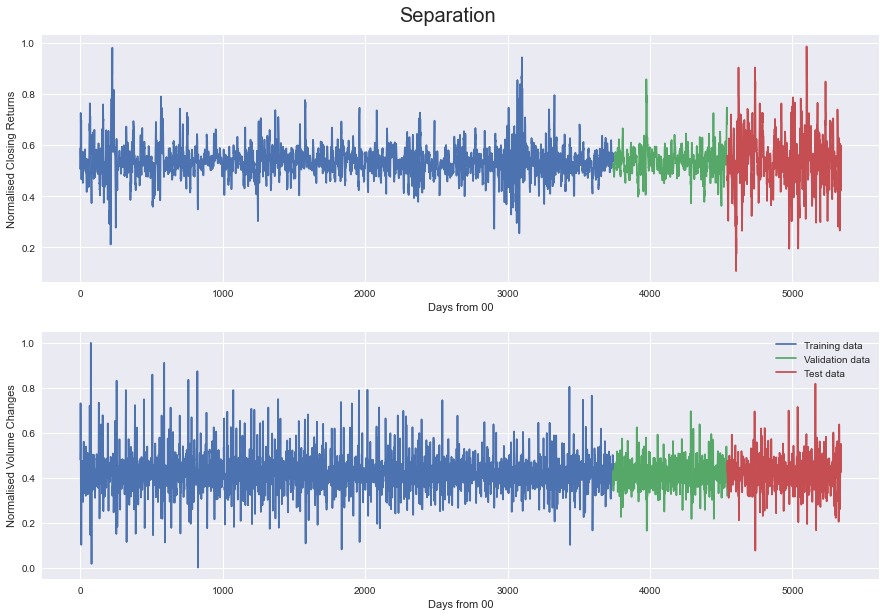

In [14]:
#Closing price and Volume daily changes
figure = plt.figure(figsize=(15,10))
suptitle = figure.suptitle("Separation", fontsize=20)
suptitle.set_y(0.92)


ax1 = figure.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_training['4. close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_validation['4. close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['4. close'], label='Test data')
ax1.set_xlabel('Days from 00')
ax1.set_ylabel('Normalised Closing Returns')


ax2 = figure.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_training['5. volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_validation['5. volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['5. volume'], label='Test data')
ax2.set_xlabel('Days from 00')
ax2.set_ylabel('Normalised Volume Changes')

plt.legend(loc='best')

# Create data shape/sequence

There are many hyperparameters that are used in our model, we will visit more when we define our models training. But here we define the shape of each learning block using the previously defined hyperparameter length.

In [15]:
#Split into subsections of data for efficiency and specific tuning
#Trasining
X_training, y_training = [], []
for i in range(hyp_par_len, len(train_data)):
  X_training.append(train_data[i-hyp_par_len:i])
  y_training.append(train_data[:, 3][i]) 
X_training, y_training = np.array(X_training), np.array(y_training)

# Validation
X_validation, y_validation = [], []
for i in range(hyp_par_len, len(val_data)):
    X_validation.append(val_data[i-hyp_par_len:i])
    y_validation.append(val_data[:, 3][i])
X_validation, y_validation = np.array(X_validation), np.array(y_validation)

# Test
X_test, y_test = [], []
for i in range(hyp_par_len, len(test_data)):
    X_test.append(test_data[i-hyp_par_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_training.shape, y_training.shape)
print(X_validation.shape, y_validation.shape)


(3666, 75, 5) (3666,)
(726, 75, 5) (726,)


# Create LSTM Model

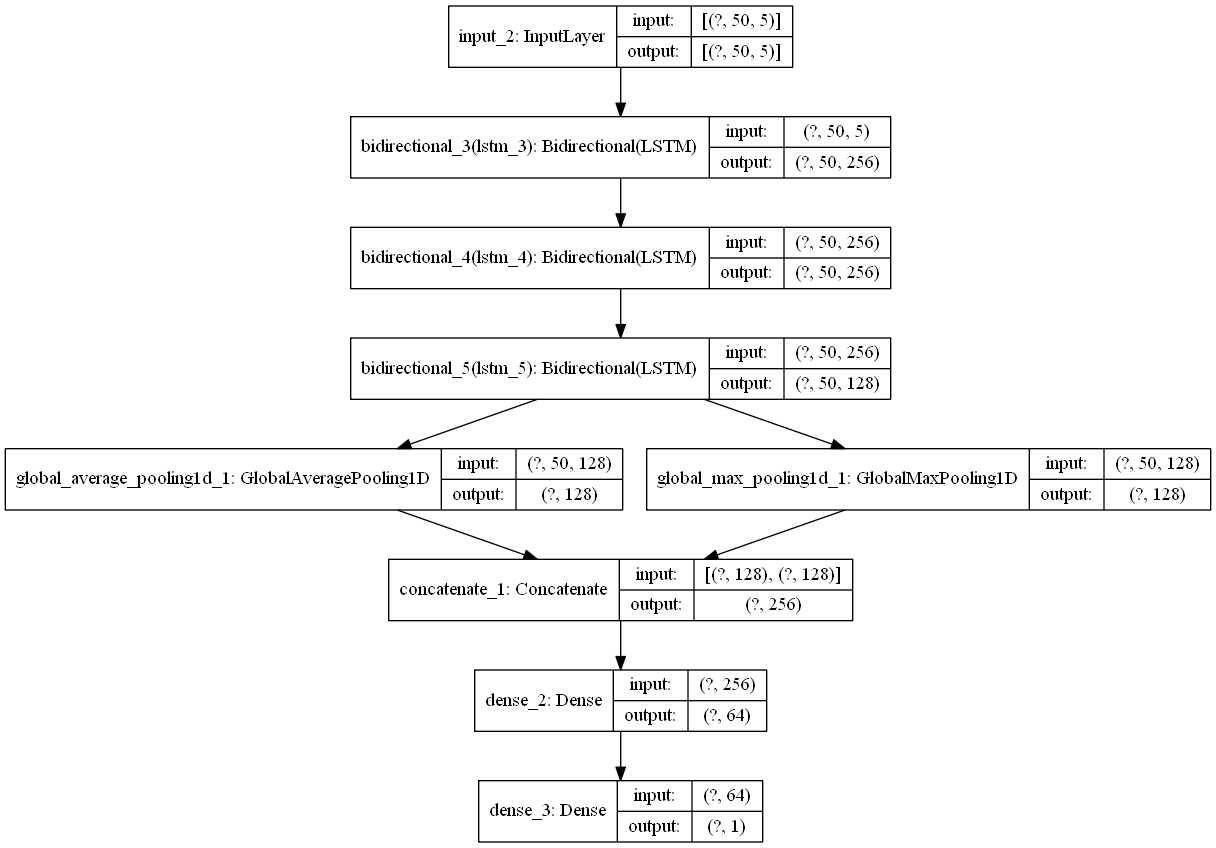

This Bi-directional LSTM uses concatenation merging by default. This means that the time distributed layer recieves 50(hyp_par_len) timesteps of 254 units (128 + 128). This is because the Bi-Directional nature is learning from the reverse copy of the input sequence. More learning is always good!

Using x is easier to add layers rather than model functions. This x can easily be passed to the Pooling functions then. Both Global Average and Global Max Pooling are run on the model and then concatenated and passed through a dense layer where the ReLU activation function is used.

Global Max Pooling takes the max input from the entire array of inputs, while Global Average Pooling  takes the average of the entire array of inputs. These Pooling functions are used to flatten the input layer, therefore, they can be passed to a dense layer.

In the dense layer the ReLU activation function is used to solve the vanashing gradient problem. Internally the LSTM model already uses the sigmoid and tahn activation functions to combat this problem but due to ReLU returning null for any negative inputs, the volatility of timeseries can be reduced.

Adam is used to optimize training using a stochastic gradient descent model. As the dataset is very noisy it is a suitable algorithm.

We measure the magnitude of errors within the models predictions using the Mean Absolute Error and Mean Absolute Percentage Error functions. These metrics are what we will base our success on.

In [16]:
def LSTM_model():
  sequence = Input(shape = (hyp_par_len, 5))
      
  x =  Bidirectional(LSTM(128, return_sequences=True))(sequence)
  x =  Bidirectional(LSTM(128, return_sequences=True))(x)
  x =  Bidirectional(LSTM(64, return_sequences=True))(x) 

#Pooling
  avg_pooling = GlobalAveragePooling1D()(x)
  max_pooling = GlobalMaxPooling1D()(x)
  addPools = concatenate([avg_pooling, max_pooling])
    
#Linear Activation Function
  addPools = Dense(64, activation="relu")(addPools)
  out = Dense(1, activation="sigmoid")(addPools)      

  lstm = tf.keras.Model(inputs=sequence, outputs=out)
  lstm.compile(loss="mse", optimizer="adam", metrics=['mae', 'mape'])

#Draw model
  #dot_img_file = r'.\model_1.png'
  #tf.keras.utils.plot_model(lstm, to_file=dot_img_file, show_shapes=True)
  return lstm

#Run model
lstm = LSTM_model()

callback = tf.keras.callbacks.ModelCheckpoint('BI-LSTM-2.hdf5', monitor='val_loss', save_best_only=True, verbose=1)

# Begin Training of Model

In [17]:
lstm.fit(X_training, y_training,
              batch_size=1024,
              verbose=2,
              callbacks=[callback],
              epochs=1000,
              validation_data=(X_validation, y_validation),)    

Train on 3666 samples, validate on 726 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.00300, saving model to BI-LSTM-2.hdf5
3666/3666 - 11s - loss: 0.0056 - mae: 0.0556 - mape: 10.6206 - val_loss: 0.0030 - val_mae: 0.0399 - val_mape: 7.4579
Epoch 2/1000

Epoch 00002: val_loss did not improve from 0.00300
3666/3666 - 1s - loss: 0.0041 - mae: 0.0455 - mape: 8.7868 - val_loss: 0.0032 - val_mae: 0.0415 - val_mape: 7.6247
Epoch 3/1000

Epoch 00003: val_loss improved from 0.00300 to 0.00298, saving model to BI-LSTM-2.hdf5
3666/3666 - 1s - loss: 0.0041 - mae: 0.0449 - mape: 8.5481 - val_loss: 0.0030 - val_mae: 0.0398 - val_mape: 7.5585
Epoch 4/1000

Epoch 00004: val_loss improved from 0.00298 to 0.00297, saving model to BI-LSTM-2.hdf5
3666/3666 - 1s - loss: 0.0040 - mae: 0.0443 - mape: 8.4190 - val_loss: 0.0030 - val_mae: 0.0396 - val_mape: 7.4760
Epoch 5/1000

Epoch 00005: val_loss did not improve from 0.00297
3666/3666 - 1s - loss: 0.0040 - mae: 0.0446 - mape: 8.6201 - v

Epoch 42/1000

Epoch 00042: val_loss did not improve from 0.00156
3666/3666 - 1s - loss: 0.0024 - mae: 0.0352 - mape: 6.6710 - val_loss: 0.0033 - val_mae: 0.0487 - val_mape: 9.4720
Epoch 43/1000

Epoch 00043: val_loss did not improve from 0.00156
3666/3666 - 1s - loss: 0.0037 - mae: 0.0481 - mape: 9.1442 - val_loss: 0.0020 - val_mae: 0.0331 - val_mape: 6.4513
Epoch 44/1000

Epoch 00044: val_loss did not improve from 0.00156
3666/3666 - 1s - loss: 0.0030 - mae: 0.0397 - mape: 7.4537 - val_loss: 0.0021 - val_mae: 0.0343 - val_mape: 6.7008
Epoch 45/1000

Epoch 00045: val_loss did not improve from 0.00156
3666/3666 - 1s - loss: 0.0028 - mae: 0.0384 - mape: 7.4754 - val_loss: 0.0018 - val_mae: 0.0307 - val_mape: 5.6696
Epoch 46/1000

Epoch 00046: val_loss did not improve from 0.00156
3666/3666 - 1s - loss: 0.0025 - mae: 0.0358 - mape: 6.9030 - val_loss: 0.0017 - val_mae: 0.0301 - val_mape: 5.5668
Epoch 47/1000

Epoch 00047: val_loss improved from 0.00156 to 0.00142, saving model to BI-LSTM-


Epoch 00085: val_loss improved from 0.00057 to 0.00051, saving model to BI-LSTM-2.hdf5
3666/3666 - 1s - loss: 0.0011 - mae: 0.0240 - mape: 4.5437 - val_loss: 5.1453e-04 - val_mae: 0.0164 - val_mape: 3.1287
Epoch 86/1000

Epoch 00086: val_loss did not improve from 0.00051
3666/3666 - 1s - loss: 0.0010 - mae: 0.0228 - mape: 4.3644 - val_loss: 5.3682e-04 - val_mae: 0.0170 - val_mape: 3.2621
Epoch 87/1000

Epoch 00087: val_loss did not improve from 0.00051
3666/3666 - 1s - loss: 9.5328e-04 - mae: 0.0213 - mape: 4.0919 - val_loss: 6.7663e-04 - val_mae: 0.0198 - val_mape: 3.6317
Epoch 88/1000

Epoch 00088: val_loss did not improve from 0.00051
3666/3666 - 1s - loss: 9.4342e-04 - mae: 0.0213 - mape: 4.0588 - val_loss: 5.4701e-04 - val_mae: 0.0176 - val_mape: 3.3819
Epoch 89/1000

Epoch 00089: val_loss did not improve from 0.00051
3666/3666 - 1s - loss: 8.7933e-04 - mae: 0.0205 - mape: 3.9386 - val_loss: 5.3300e-04 - val_mae: 0.0173 - val_mape: 3.1888
Epoch 90/1000

Epoch 00090: val_loss impr

Epoch 127/1000

Epoch 00127: val_loss did not improve from 0.00038
3666/3666 - 1s - loss: 8.0442e-04 - mae: 0.0199 - mape: 3.7875 - val_loss: 4.1954e-04 - val_mae: 0.0149 - val_mape: 2.7729
Epoch 128/1000

Epoch 00128: val_loss improved from 0.00038 to 0.00038, saving model to BI-LSTM-2.hdf5
3666/3666 - 1s - loss: 8.0072e-04 - mae: 0.0200 - mape: 3.8022 - val_loss: 3.7692e-04 - val_mae: 0.0138 - val_mape: 2.5969
Epoch 129/1000

Epoch 00129: val_loss did not improve from 0.00038
3666/3666 - 1s - loss: 7.1681e-04 - mae: 0.0178 - mape: 3.4039 - val_loss: 3.8616e-04 - val_mae: 0.0140 - val_mape: 2.6585
Epoch 130/1000

Epoch 00130: val_loss did not improve from 0.00038
3666/3666 - 1s - loss: 6.7456e-04 - mae: 0.0169 - mape: 3.2454 - val_loss: 4.5297e-04 - val_mae: 0.0160 - val_mape: 2.9601
Epoch 131/1000

Epoch 00131: val_loss did not improve from 0.00038
3666/3666 - 1s - loss: 7.0686e-04 - mae: 0.0178 - mape: 3.3849 - val_loss: 6.3041e-04 - val_mae: 0.0198 - val_mape: 3.7729
Epoch 132/1000

Epoch 170/1000

Epoch 00170: val_loss did not improve from 0.00036
3666/3666 - 1s - loss: 7.0382e-04 - mae: 0.0180 - mape: 3.4019 - val_loss: 4.1304e-04 - val_mae: 0.0147 - val_mape: 2.8046
Epoch 171/1000

Epoch 00171: val_loss did not improve from 0.00036
3666/3666 - 1s - loss: 6.8864e-04 - mae: 0.0177 - mape: 3.3712 - val_loss: 4.2148e-04 - val_mae: 0.0152 - val_mape: 2.8107
Epoch 172/1000

Epoch 00172: val_loss did not improve from 0.00036
3666/3666 - 1s - loss: 7.1384e-04 - mae: 0.0179 - mape: 3.3932 - val_loss: 4.8767e-04 - val_mae: 0.0166 - val_mape: 3.1729
Epoch 173/1000

Epoch 00173: val_loss did not improve from 0.00036
3666/3666 - 1s - loss: 7.1300e-04 - mae: 0.0183 - mape: 3.4919 - val_loss: 4.0688e-04 - val_mae: 0.0148 - val_mape: 2.7423
Epoch 174/1000

Epoch 00174: val_loss did not improve from 0.00036
3666/3666 - 1s - loss: 6.9527e-04 - mae: 0.0177 - mape: 3.3556 - val_loss: 4.2555e-04 - val_mae: 0.0150 - val_mape: 2.8704
Epoch 175/1000

Epoch 00175: val_loss did not impr

Epoch 213/1000

Epoch 00213: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 0.0033 - mae: 0.0414 - mape: 7.9061 - val_loss: 0.0020 - val_mae: 0.0329 - val_mape: 6.2351
Epoch 214/1000

Epoch 00214: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 0.0029 - mae: 0.0391 - mape: 7.6346 - val_loss: 0.0026 - val_mae: 0.0384 - val_mape: 6.9037
Epoch 215/1000

Epoch 00215: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 0.0030 - mae: 0.0394 - mape: 7.4949 - val_loss: 0.0018 - val_mae: 0.0311 - val_mape: 5.7320
Epoch 216/1000

Epoch 00216: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 0.0024 - mae: 0.0354 - mape: 6.7144 - val_loss: 0.0015 - val_mae: 0.0282 - val_mape: 5.1716
Epoch 217/1000

Epoch 00217: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 0.0023 - mae: 0.0354 - mape: 6.7067 - val_loss: 0.0012 - val_mae: 0.0250 - val_mape: 4.6123
Epoch 218/1000

Epoch 00218: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 

Epoch 258/1000

Epoch 00258: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 0.0011 - mae: 0.0228 - mape: 4.3294 - val_loss: 0.0010 - val_mae: 0.0256 - val_mape: 4.9509
Epoch 259/1000

Epoch 00259: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 0.0012 - mae: 0.0255 - mape: 4.8839 - val_loss: 5.8401e-04 - val_mae: 0.0176 - val_mape: 3.2713
Epoch 260/1000

Epoch 00260: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 9.5756e-04 - mae: 0.0209 - mape: 3.9734 - val_loss: 6.2832e-04 - val_mae: 0.0184 - val_mape: 3.5256
Epoch 261/1000

Epoch 00261: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 0.0010 - mae: 0.0222 - mape: 4.2516 - val_loss: 6.8893e-04 - val_mae: 0.0201 - val_mape: 3.6970
Epoch 262/1000

Epoch 00262: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 0.0010 - mae: 0.0220 - mape: 4.1693 - val_loss: 7.5525e-04 - val_mae: 0.0210 - val_mape: 4.0445
Epoch 263/1000

Epoch 00263: val_loss did not improve from 0.00035
366

Epoch 302/1000

Epoch 00302: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 9.1899e-04 - mae: 0.0207 - mape: 3.9240 - val_loss: 5.1016e-04 - val_mae: 0.0162 - val_mape: 3.0788
Epoch 303/1000

Epoch 00303: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 8.8652e-04 - mae: 0.0200 - mape: 3.8187 - val_loss: 5.3403e-04 - val_mae: 0.0167 - val_mape: 3.1752
Epoch 304/1000

Epoch 00304: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 9.8212e-04 - mae: 0.0221 - mape: 4.2318 - val_loss: 6.9035e-04 - val_mae: 0.0205 - val_mape: 3.7632
Epoch 305/1000

Epoch 00305: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 9.7975e-04 - mae: 0.0216 - mape: 4.0954 - val_loss: 5.0443e-04 - val_mae: 0.0161 - val_mape: 3.0420
Epoch 306/1000

Epoch 00306: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 8.6982e-04 - mae: 0.0197 - mape: 3.7653 - val_loss: 5.0865e-04 - val_mae: 0.0162 - val_mape: 3.0635
Epoch 307/1000

Epoch 00307: val_loss did not impr

Epoch 346/1000

Epoch 00346: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 8.5332e-04 - mae: 0.0198 - mape: 3.7640 - val_loss: 5.3940e-04 - val_mae: 0.0169 - val_mape: 3.2182
Epoch 347/1000

Epoch 00347: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 8.5551e-04 - mae: 0.0198 - mape: 3.7747 - val_loss: 4.7675e-04 - val_mae: 0.0158 - val_mape: 2.9697
Epoch 348/1000

Epoch 00348: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 8.4298e-04 - mae: 0.0195 - mape: 3.7249 - val_loss: 5.6348e-04 - val_mae: 0.0179 - val_mape: 3.3177
Epoch 349/1000

Epoch 00349: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 8.8525e-04 - mae: 0.0203 - mape: 3.8537 - val_loss: 5.9429e-04 - val_mae: 0.0181 - val_mape: 3.4640
Epoch 350/1000

Epoch 00350: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 9.2802e-04 - mae: 0.0214 - mape: 4.0758 - val_loss: 7.2659e-04 - val_mae: 0.0214 - val_mape: 3.9204
Epoch 351/1000

Epoch 00351: val_loss did not impr

Epoch 390/1000

Epoch 00390: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 8.9040e-04 - mae: 0.0207 - mape: 3.9474 - val_loss: 5.8380e-04 - val_mae: 0.0185 - val_mape: 3.4071
Epoch 391/1000

Epoch 00391: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 9.0568e-04 - mae: 0.0209 - mape: 3.9534 - val_loss: 7.4823e-04 - val_mae: 0.0214 - val_mape: 4.1149
Epoch 392/1000

Epoch 00392: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 9.5996e-04 - mae: 0.0220 - mape: 4.2001 - val_loss: 6.4497e-04 - val_mae: 0.0198 - val_mape: 3.6483
Epoch 393/1000

Epoch 00393: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 9.4333e-04 - mae: 0.0217 - mape: 4.1104 - val_loss: 4.8201e-04 - val_mae: 0.0157 - val_mape: 2.9870
Epoch 394/1000

Epoch 00394: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 8.6263e-04 - mae: 0.0201 - mape: 3.8267 - val_loss: 4.6149e-04 - val_mae: 0.0154 - val_mape: 2.9126
Epoch 395/1000

Epoch 00395: val_loss did not impr

Epoch 434/1000

Epoch 00434: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 8.7703e-04 - mae: 0.0205 - mape: 3.8903 - val_loss: 7.5909e-04 - val_mae: 0.0217 - val_mape: 4.1822
Epoch 435/1000

Epoch 00435: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 0.0010 - mae: 0.0234 - mape: 4.4562 - val_loss: 7.4867e-04 - val_mae: 0.0220 - val_mape: 4.0300
Epoch 436/1000

Epoch 00436: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 0.0011 - mae: 0.0241 - mape: 4.5628 - val_loss: 5.2686e-04 - val_mae: 0.0172 - val_mape: 3.1833
Epoch 437/1000

Epoch 00437: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 8.9794e-04 - mae: 0.0208 - mape: 3.9528 - val_loss: 5.9504e-04 - val_mae: 0.0182 - val_mape: 3.4990
Epoch 438/1000

Epoch 00438: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 8.5690e-04 - mae: 0.0201 - mape: 3.8432 - val_loss: 4.5497e-04 - val_mae: 0.0152 - val_mape: 2.8818
Epoch 439/1000

Epoch 00439: val_loss did not improve from

Epoch 478/1000

Epoch 00478: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 8.1843e-04 - mae: 0.0194 - mape: 3.7150 - val_loss: 4.5739e-04 - val_mae: 0.0157 - val_mape: 2.9356
Epoch 479/1000

Epoch 00479: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 7.7464e-04 - mae: 0.0186 - mape: 3.5317 - val_loss: 4.3067e-04 - val_mae: 0.0148 - val_mape: 2.8056
Epoch 480/1000

Epoch 00480: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 7.5646e-04 - mae: 0.0182 - mape: 3.4608 - val_loss: 4.2979e-04 - val_mae: 0.0148 - val_mape: 2.8000
Epoch 481/1000

Epoch 00481: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 7.5644e-04 - mae: 0.0182 - mape: 3.4603 - val_loss: 4.2742e-04 - val_mae: 0.0149 - val_mape: 2.7996
Epoch 482/1000

Epoch 00482: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 7.5168e-04 - mae: 0.0180 - mape: 3.4291 - val_loss: 4.2508e-04 - val_mae: 0.0148 - val_mape: 2.7881
Epoch 483/1000

Epoch 00483: val_loss did not impr

Epoch 522/1000

Epoch 00522: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 8.0230e-04 - mae: 0.0195 - mape: 3.6837 - val_loss: 6.5180e-04 - val_mae: 0.0198 - val_mape: 3.8063
Epoch 523/1000

Epoch 00523: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 8.5782e-04 - mae: 0.0204 - mape: 3.9071 - val_loss: 5.0297e-04 - val_mae: 0.0169 - val_mape: 3.1284
Epoch 524/1000

Epoch 00524: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 8.4854e-04 - mae: 0.0204 - mape: 3.8584 - val_loss: 4.3658e-04 - val_mae: 0.0153 - val_mape: 2.8453
Epoch 525/1000

Epoch 00525: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 8.5330e-04 - mae: 0.0204 - mape: 3.8637 - val_loss: 7.0048e-04 - val_mae: 0.0208 - val_mape: 4.0076
Epoch 526/1000

Epoch 00526: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 9.7737e-04 - mae: 0.0229 - mape: 4.3907 - val_loss: 8.1642e-04 - val_mae: 0.0235 - val_mape: 4.3158
Epoch 527/1000

Epoch 00527: val_loss did not impr

Epoch 566/1000

Epoch 00566: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 8.1132e-04 - mae: 0.0198 - mape: 3.7487 - val_loss: 4.1094e-04 - val_mae: 0.0144 - val_mape: 2.7215
Epoch 567/1000

Epoch 00567: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 7.9021e-04 - mae: 0.0193 - mape: 3.6800 - val_loss: 4.2472e-04 - val_mae: 0.0146 - val_mape: 2.7862
Epoch 568/1000

Epoch 00568: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 7.7269e-04 - mae: 0.0189 - mape: 3.6081 - val_loss: 4.6045e-04 - val_mae: 0.0160 - val_mape: 2.9748
Epoch 569/1000

Epoch 00569: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 7.4014e-04 - mae: 0.0181 - mape: 3.4388 - val_loss: 4.0816e-04 - val_mae: 0.0143 - val_mape: 2.7207
Epoch 570/1000

Epoch 00570: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 7.1991e-04 - mae: 0.0177 - mape: 3.3813 - val_loss: 4.1865e-04 - val_mae: 0.0150 - val_mape: 2.7927
Epoch 571/1000

Epoch 00571: val_loss did not impr

Epoch 610/1000

Epoch 00610: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 7.7378e-04 - mae: 0.0191 - mape: 3.6416 - val_loss: 5.6848e-04 - val_mae: 0.0186 - val_mape: 3.4325
Epoch 611/1000

Epoch 00611: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 7.6357e-04 - mae: 0.0187 - mape: 3.5412 - val_loss: 4.0428e-04 - val_mae: 0.0142 - val_mape: 2.7006
Epoch 612/1000

Epoch 00612: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 6.9928e-04 - mae: 0.0173 - mape: 3.2980 - val_loss: 4.0649e-04 - val_mae: 0.0146 - val_mape: 2.7209
Epoch 613/1000

Epoch 00613: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 7.2664e-04 - mae: 0.0179 - mape: 3.3909 - val_loss: 3.9629e-04 - val_mae: 0.0143 - val_mape: 2.6720
Epoch 614/1000

Epoch 00614: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 7.5018e-04 - mae: 0.0183 - mape: 3.4760 - val_loss: 5.0663e-04 - val_mae: 0.0168 - val_mape: 3.2132
Epoch 615/1000

Epoch 00615: val_loss did not impr

Epoch 654/1000

Epoch 00654: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 7.6811e-04 - mae: 0.0189 - mape: 3.5810 - val_loss: 4.0274e-04 - val_mae: 0.0142 - val_mape: 2.7043
Epoch 655/1000

Epoch 00655: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 7.2404e-04 - mae: 0.0178 - mape: 3.4067 - val_loss: 3.8973e-04 - val_mae: 0.0142 - val_mape: 2.6555
Epoch 656/1000

Epoch 00656: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 6.8475e-04 - mae: 0.0171 - mape: 3.2477 - val_loss: 3.9583e-04 - val_mae: 0.0140 - val_mape: 2.6720
Epoch 657/1000

Epoch 00657: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 6.8464e-04 - mae: 0.0170 - mape: 3.2430 - val_loss: 3.7805e-04 - val_mae: 0.0138 - val_mape: 2.5957
Epoch 658/1000

Epoch 00658: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 6.8365e-04 - mae: 0.0171 - mape: 3.2538 - val_loss: 3.7872e-04 - val_mae: 0.0138 - val_mape: 2.5933
Epoch 659/1000

Epoch 00659: val_loss did not impr

Epoch 698/1000

Epoch 00698: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 6.8306e-04 - mae: 0.0173 - mape: 3.2948 - val_loss: 4.0228e-04 - val_mae: 0.0145 - val_mape: 2.7104
Epoch 699/1000

Epoch 00699: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 6.8325e-04 - mae: 0.0171 - mape: 3.2557 - val_loss: 3.7710e-04 - val_mae: 0.0136 - val_mape: 2.5824
Epoch 700/1000

Epoch 00700: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 6.6297e-04 - mae: 0.0167 - mape: 3.1720 - val_loss: 4.2271e-04 - val_mae: 0.0148 - val_mape: 2.8290
Epoch 701/1000

Epoch 00701: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 7.2816e-04 - mae: 0.0183 - mape: 3.4925 - val_loss: 3.8163e-04 - val_mae: 0.0140 - val_mape: 2.6180
Epoch 702/1000

Epoch 00702: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 7.4043e-04 - mae: 0.0186 - mape: 3.5201 - val_loss: 4.2429e-04 - val_mae: 0.0152 - val_mape: 2.8206
Epoch 703/1000

Epoch 00703: val_loss did not impr

Epoch 742/1000

Epoch 00742: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 6.7586e-04 - mae: 0.0172 - mape: 3.2593 - val_loss: 3.9468e-04 - val_mae: 0.0141 - val_mape: 2.6858
Epoch 743/1000

Epoch 00743: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 7.0720e-04 - mae: 0.0179 - mape: 3.4084 - val_loss: 3.6938e-04 - val_mae: 0.0136 - val_mape: 2.5546
Epoch 744/1000

Epoch 00744: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 7.4855e-04 - mae: 0.0190 - mape: 3.6088 - val_loss: 4.5247e-04 - val_mae: 0.0160 - val_mape: 2.9564
Epoch 745/1000

Epoch 00745: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 7.1370e-04 - mae: 0.0180 - mape: 3.4114 - val_loss: 5.2442e-04 - val_mae: 0.0174 - val_mape: 3.3408
Epoch 746/1000

Epoch 00746: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 7.3633e-04 - mae: 0.0187 - mape: 3.5576 - val_loss: 4.6293e-04 - val_mae: 0.0163 - val_mape: 3.0135
Epoch 747/1000

Epoch 00747: val_loss did not impr

Epoch 786/1000

Epoch 00786: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 8.1006e-04 - mae: 0.0200 - mape: 3.7770 - val_loss: 4.9972e-04 - val_mae: 0.0168 - val_mape: 3.2257
Epoch 787/1000

Epoch 00787: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 7.7350e-04 - mae: 0.0195 - mape: 3.7135 - val_loss: 4.7696e-04 - val_mae: 0.0166 - val_mape: 3.0715
Epoch 788/1000

Epoch 00788: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 6.9832e-04 - mae: 0.0178 - mape: 3.3786 - val_loss: 3.8657e-04 - val_mae: 0.0139 - val_mape: 2.6430
Epoch 789/1000

Epoch 00789: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 7.2459e-04 - mae: 0.0183 - mape: 3.4969 - val_loss: 3.6678e-04 - val_mae: 0.0134 - val_mape: 2.5381
Epoch 790/1000

Epoch 00790: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 7.1231e-04 - mae: 0.0180 - mape: 3.4243 - val_loss: 4.0969e-04 - val_mae: 0.0148 - val_mape: 2.7614
Epoch 791/1000

Epoch 00791: val_loss did not impr

Epoch 830/1000

Epoch 00830: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 7.6660e-04 - mae: 0.0192 - mape: 3.6598 - val_loss: 6.1844e-04 - val_mae: 0.0200 - val_mape: 3.6775
Epoch 831/1000

Epoch 00831: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 7.9708e-04 - mae: 0.0199 - mape: 3.7754 - val_loss: 3.6710e-04 - val_mae: 0.0134 - val_mape: 2.5415
Epoch 832/1000

Epoch 00832: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 7.7519e-04 - mae: 0.0196 - mape: 3.7236 - val_loss: 4.8849e-04 - val_mae: 0.0165 - val_mape: 3.1710
Epoch 833/1000

Epoch 00833: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 7.4350e-04 - mae: 0.0188 - mape: 3.5814 - val_loss: 4.0665e-04 - val_mae: 0.0147 - val_mape: 2.7446
Epoch 834/1000

Epoch 00834: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 7.1157e-04 - mae: 0.0182 - mape: 3.4496 - val_loss: 4.7089e-04 - val_mae: 0.0165 - val_mape: 3.0516
Epoch 835/1000

Epoch 00835: val_loss did not impr

Epoch 874/1000

Epoch 00874: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 6.9479e-04 - mae: 0.0177 - mape: 3.3820 - val_loss: 6.2650e-04 - val_mae: 0.0201 - val_mape: 3.7087
Epoch 875/1000

Epoch 00875: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 8.2370e-04 - mae: 0.0203 - mape: 3.8335 - val_loss: 5.2208e-04 - val_mae: 0.0174 - val_mape: 3.3417
Epoch 876/1000

Epoch 00876: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 7.1608e-04 - mae: 0.0181 - mape: 3.4559 - val_loss: 4.0215e-04 - val_mae: 0.0147 - val_mape: 2.7287
Epoch 877/1000

Epoch 00877: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 6.5310e-04 - mae: 0.0167 - mape: 3.1607 - val_loss: 3.6264e-04 - val_mae: 0.0133 - val_mape: 2.5223
Epoch 878/1000

Epoch 00878: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 6.3873e-04 - mae: 0.0164 - mape: 3.1221 - val_loss: 4.1311e-04 - val_mae: 0.0150 - val_mape: 2.7839
Epoch 879/1000

Epoch 00879: val_loss did not impr

Epoch 918/1000

Epoch 00918: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 0.0025 - mae: 0.0363 - mape: 6.9726 - val_loss: 0.0017 - val_mae: 0.0299 - val_mape: 5.5666
Epoch 919/1000

Epoch 00919: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 0.0025 - mae: 0.0358 - mape: 6.8401 - val_loss: 0.0017 - val_mae: 0.0294 - val_mape: 5.5770
Epoch 920/1000

Epoch 00920: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 0.0023 - mae: 0.0339 - mape: 6.4730 - val_loss: 0.0016 - val_mae: 0.0292 - val_mape: 5.5922
Epoch 921/1000

Epoch 00921: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 0.0022 - mae: 0.0329 - mape: 6.2655 - val_loss: 0.0015 - val_mae: 0.0277 - val_mape: 5.2726
Epoch 922/1000

Epoch 00922: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 0.0020 - mae: 0.0315 - mape: 5.9975 - val_loss: 0.0014 - val_mae: 0.0281 - val_mape: 5.4480
Epoch 923/1000

Epoch 00923: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 

Epoch 963/1000

Epoch 00963: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 9.4695e-04 - mae: 0.0203 - mape: 3.8472 - val_loss: 5.5525e-04 - val_mae: 0.0169 - val_mape: 3.0884
Epoch 964/1000

Epoch 00964: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 9.8521e-04 - mae: 0.0213 - mape: 4.0027 - val_loss: 7.5233e-04 - val_mae: 0.0214 - val_mape: 4.0991
Epoch 965/1000

Epoch 00965: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 0.0010 - mae: 0.0219 - mape: 4.1649 - val_loss: 5.9727e-04 - val_mae: 0.0179 - val_mape: 3.2566
Epoch 966/1000

Epoch 00966: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 9.7572e-04 - mae: 0.0212 - mape: 4.0007 - val_loss: 4.8398e-04 - val_mae: 0.0151 - val_mape: 2.7995
Epoch 967/1000

Epoch 00967: val_loss did not improve from 0.00035
3666/3666 - 1s - loss: 0.0011 - mae: 0.0230 - mape: 4.3562 - val_loss: 4.7799e-04 - val_mae: 0.0150 - val_mape: 2.8143
Epoch 968/1000

Epoch 00968: val_loss did not improve from

# Load Model

In [18]:
lstm = tf.keras.models.load_model(r'.\Bi-LSTM-2.hdf5')

# Evaluate Model

In [19]:
#Prdict
train_pred = lstm.predict(X_training)
val_pred = lstm.predict(X_validation)
test_pred = lstm.predict(X_test)

#Print evaluation metrics for all datasets
training_eval = lstm.evaluate(X_training, y_training, verbose=0)
validation_eval = lstm.evaluate(X_validation, y_validation, verbose=0)
test_eval = lstm.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Metrics')
print('Training - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(training_eval[0], training_eval[1], training_eval[2]))
print('Validation - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(validation_eval[0], validation_eval[1], validation_eval[2]))
print('Test - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

 
Metrics
Training - Loss: 0.0006, MAE: 0.0162, MAPE: 3.0823
Validation - Loss: 0.0004, MAE: 0.0133, MAPE: 2.5022
Test - Loss: 0.0018, MAE: 0.0293, MAPE: 5.8024


# Visualise Result

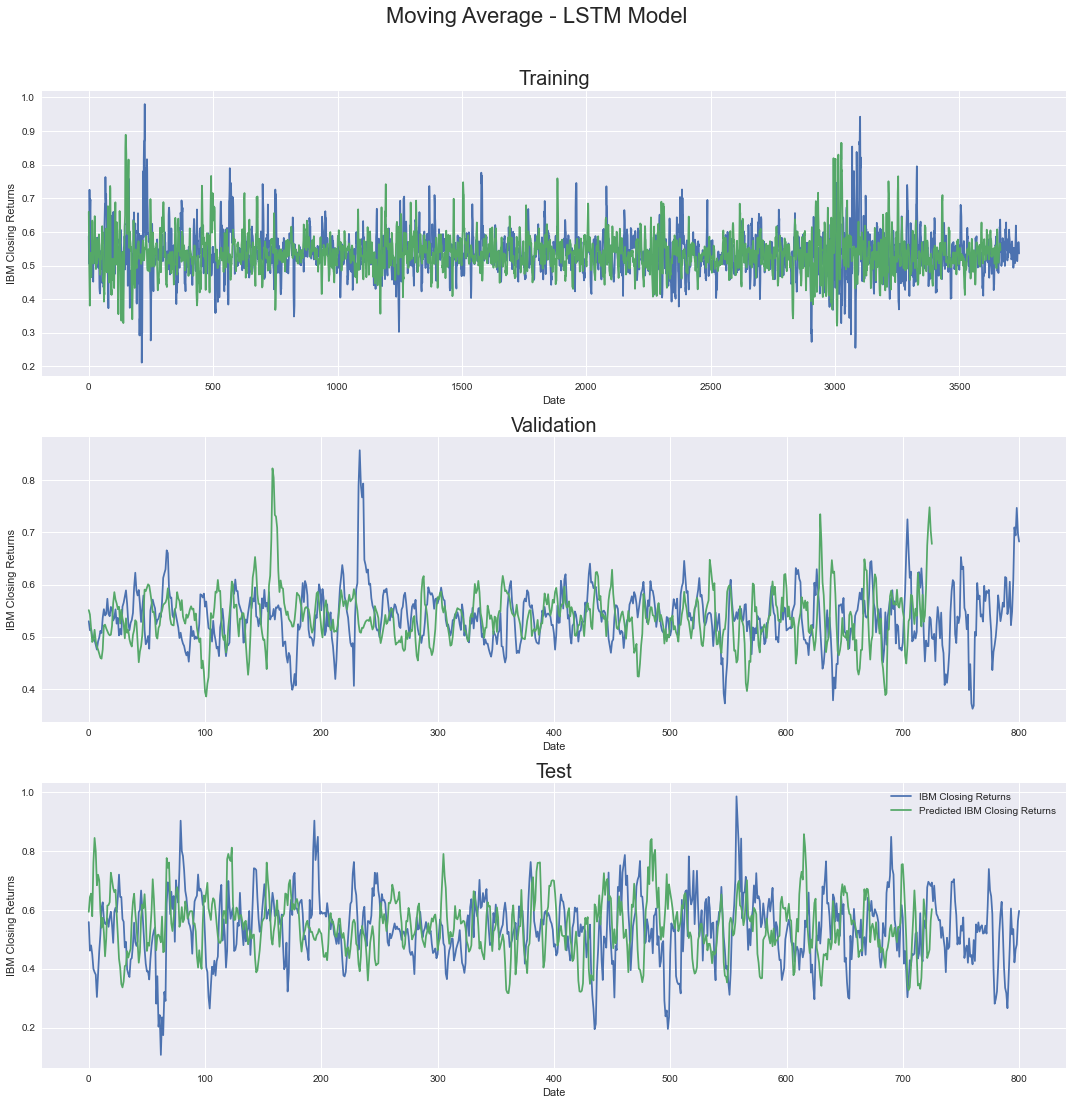

In [20]:
#Plot results
figure = plt.figure(figsize=(15,15))
suptitle = figure.suptitle("Moving Average - LSTM Model", fontsize=22)
suptitle.set_y(1.02)

#training
ax11 = figure.add_subplot(311)
ax11.plot(train_data[:, 3], label='IBM Closing Returns')
ax11.plot(train_pred, label='Predicted IBM Closing Returns')
ax11.set_title("Training", fontsize=20)
ax11.set_xlabel('Date')
ax11.set_ylabel('IBM Closing Returns')

#validation
ax21 = figure.add_subplot(312)
ax21.plot(val_data[:, 3], label='IBM Closing Returns')
ax21.plot(val_pred, label='Predicted IBM Closing Returns')
ax21.set_title("Validation", fontsize=20)
ax21.set_xlabel('Date')
ax21.set_ylabel('IBM Closing Returns')

#test
ax31 = figure.add_subplot(313)
ax31.plot(test_data[:, 3], label='IBM Closing Returns')
ax31.plot(test_pred, label='Predicted IBM Closing Returns')
ax31.set_title("Test", fontsize=20)
ax31.set_xlabel('Date')
ax31.set_ylabel('IBM Closing Returns')
 
plt.tight_layout()
plt.legend(loc='best')